In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import geopandas as gpd
import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [133]:
bus_jul = pd.read_csv('carpark datasets/transport_node_bus_202107.csv')
bus_jun = pd.read_csv('carpark datasets/transport_node_bus_202106.csv')
bus_may = pd.read_csv('carpark datasets/transport_node_bus_202105.csv')
bus = bus_may.append([bus_jun,bus_jul])
bus.drop(columns=['PT_TYPE'],inplace=True)
bus.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2021-05,WEEKENDS/HOLIDAY,17,45379,143,98
1,2021-05,WEEKDAY,17,45379,378,278
2,2021-05,WEEKDAY,13,80051,1651,1803
3,2021-05,WEEKENDS/HOLIDAY,13,80051,1224,1166
4,2021-05,WEEKDAY,13,5319,41,163


In [134]:
info = pd.read_csv('bus-stop-info.csv').drop(columns=['Unnamed: 0'])
info.rename(columns={'region':'subzone'},inplace=True)

In [135]:
df = pd.merge(bus,info,left_on='PT_CODE',right_on='BusStopCode').drop(columns=['BusStopCode'])
df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,RoadName,Latitude,Longitude,subzone
0,2021-05,WEEKENDS/HOLIDAY,17,45379,143,98,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
1,2021-05,WEEKDAY,17,45379,378,278,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
2,2021-05,WEEKENDS/HOLIDAY,0,45379,6,22,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
3,2021-05,WEEKDAY,0,45379,13,27,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
4,2021-05,WEEKDAY,20,45379,147,148,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256


In [136]:
dir = f'carpark datasets/transform_2021' ## take output file from merge_all.py

all_files = glob.glob(dir + "/*.csv")
carpark = pd.DataFrame()
for f in all_files:
        if f[32:39]=='2021-05' or f[32:39]=='2021-06' or f[32:39]=='2021-07':
                carpark = carpark.append(pd.read_csv(f))
                
carpark.drop(columns=['avail_percent'], inplace=True)
carpark['date'] = pd.to_datetime(carpark['date'])
carpark['period'] = carpark['date'].dt.to_period('M')
carpark = carpark.groupby(['period','number'], as_index=False).sum()
carpark['avail_percent'] = round((carpark['available']/carpark['total']), 3) ## round up to 3dp
carpark.reset_index(drop=True, inplace=True)
carpark = carpark.merge(pd.read_csv('carpark-info.csv'),left_on='number',right_on='car_park_no')
carpark.drop(columns=['car_park_no'],inplace=True)
carpark.drop(columns=['Unnamed: 0'],inplace=True)
carpark.head()

,period,number,total,available,avail_percent,address,x_coord,y_coord,subzone
0,2021-05,A10,1984,758,0.382,BLK 201/202 ANG MO KIO STREET 22,103.844524,1.368633,kml_329
1,2021-06,A10,1920,752,0.392,BLK 201/202 ANG MO KIO STREET 22,103.844524,1.368633,kml_329
2,2021-07,A10,576,242,0.420,BLK 201/202 ANG MO KIO STREET 22,103.844524,1.368633,kml_329
3,2021-05,A100,1984,1008,0.508,BLK 650 ANG MO KIO STREET 61,103.842603,1.377987,kml_242
4,2021-06,A100,1920,1003,0.522,BLK 650 ANG MO KIO STREET 61,103.842603,1.377987,kml_242


In [137]:
change_df = pd.read_csv('may_diff.csv').append([pd.read_csv('june_diff.csv'),pd.read_csv('july_diff.csv')])
change_df=change_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)
change_df.max_time,change_df.min_time=pd.to_datetime(change_df.max_time),pd.to_datetime(change_df.min_time)
change_df

,number,total,available,occupied,max_time,max,min_time,min
0,A10,64,27,57.812500,2021-05-01 16:59:53,6.250000,2021-05-01 13:54:53,-12.500000
1,A100,64,26,59.375000,2021-05-01 09:24:53,7.812500,2021-05-01 09:54:53,-10.937500
2,A11,368,17,95.380435,2021-05-01 07:49:53,13.043478,2021-05-01 12:54:53,-10.326087
3,A12,205,68,66.829268,2021-05-01 08:19:53,6.829268,2021-05-01 10:54:53,-6.341463
4,A13,199,28,85.929648,2021-05-01 11:54:53,9.547739,2021-05-01 20:34:53,-14.070352
...,...,...,...,...,...,...,...,...
135165,Y78M,216,76,64.814815,2021-07-09 22:54:53,6.018519,2021-07-09 07:44:53,-7.870370
135166,Y8,500,112,77.600000,2021-07-09 19:49:53,7.400000,2021-07-09 07:09:53,-7.200000
135167,Y82M,900,744,17.333333,2021-07-09 23:24:53,1.555556,2021-07-09 07:44:53,-1.888889
135168,Y9,262,149,43.129771,2021-07-09 10:44:53,3.053435,2021-07-09 07:09:53,-3.053435


In [138]:
bus_df=df.copy()
bus_df

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,RoadName,Latitude,Longitude,subzone
0,2021-05,WEEKENDS/HOLIDAY,17,45379,143,98,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
1,2021-05,WEEKDAY,17,45379,378,278,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
2,2021-05,WEEKENDS/HOLIDAY,0,45379,6,22,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
3,2021-05,WEEKDAY,0,45379,13,27,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
4,2021-05,WEEKDAY,20,45379,147,148,Choa Chu Kang Nth 6,1.394694,103.751873,kml_256
...,...,...,...,...,...,...,...,...,...,...
573512,2021-06,WEEKDAY,19,64259,1,12,Hougang St 91,1.377060,103.883230,kml_243
573513,2021-07,WEEKDAY,19,64259,0,12,Hougang St 91,1.377060,103.883230,kml_243
573514,2021-05,WEEKDAY,7,64251,190,2,Hougang St 91,1.377190,103.882710,kml_243
573515,2021-06,WEEKDAY,7,64251,162,0,Hougang St 91,1.377190,103.882710,kml_243


In [139]:
cp_df=change_df.merge(pd.read_csv('carpark-info.csv')[['car_park_no','subzone']],left_on='number',right_on='car_park_no',how='inner')
cp_df

,number,total,available,occupied,max_time,max,min_time,min,car_park_no,subzone
0,A10,64,27,57.8125,2021-05-01 16:59:53,6.250000,2021-05-01 13:54:53,-12.500000,A10,kml_329
1,A10,64,9,85.9375,2021-05-02 09:49:53,7.812500,2021-05-02 12:19:53,-15.625000,A10,kml_329
2,A10,64,30,53.1250,2021-05-03 16:44:53,12.500000,2021-05-03 08:39:53,-17.187500,A10,kml_329
3,A10,64,35,45.3125,2021-05-04 14:59:53,10.937500,2021-05-04 09:29:53,-14.062500,A10,kml_329
4,A10,64,31,51.5625,2021-05-05 16:54:53,9.375000,2021-05-05 08:44:53,-7.812500,A10,kml_329
...,...,...,...,...,...,...,...,...,...,...
131175,YHS,64,19,70.3125,2021-07-05 00:09:53,0.000000,2021-07-05 02:34:53,-14.062500,YHS,kml_37
131176,YHS,64,22,65.6250,2021-07-06 02:59:53,9.375000,2021-07-06 00:09:53,0.000000,YHS,kml_37
131177,YHS,64,12,81.2500,2021-07-07 22:14:53,24.886364,2021-07-07 22:09:53,-24.886364,YHS,kml_37
131178,YHS,64,12,81.2500,2021-07-08 00:09:53,0.000000,2021-07-08 01:14:53,-4.687500,YHS,kml_37


In [140]:
len(cp_df.subzone.unique())

151

<AxesSubplot:xlabel='max_time', ylabel='count'>

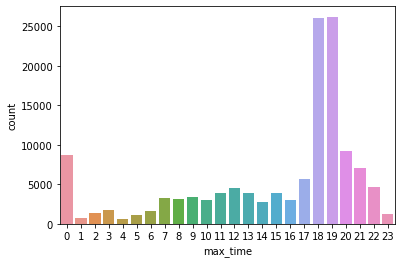

In [141]:
sns.countplot(cp_df.max_time.dt.hour)

<AxesSubplot:xlabel='min_time', ylabel='count'>

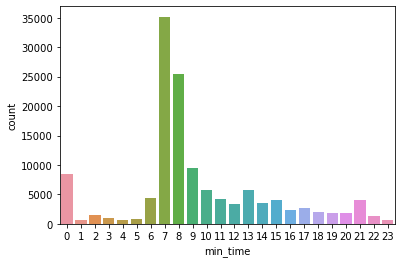

In [142]:
sns.countplot(cp_df.min_time.dt.hour)

<AxesSubplot:xlabel='TIME_PER_HOUR', ylabel='TOTAL_TAP_IN_VOLUME'>

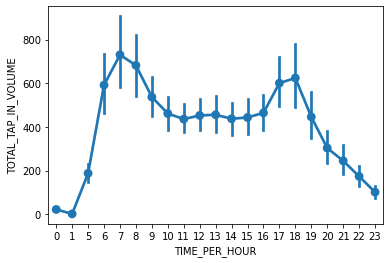

In [143]:
sns.pointplot(x=bus_df[bus_df.subzone=='kml_100'].TIME_PER_HOUR,y=bus_df[bus_df.subzone=='kml_100'].TOTAL_TAP_IN_VOLUME)

<AxesSubplot:xlabel='TIME_PER_HOUR', ylabel='TOTAL_TAP_OUT_VOLUME'>

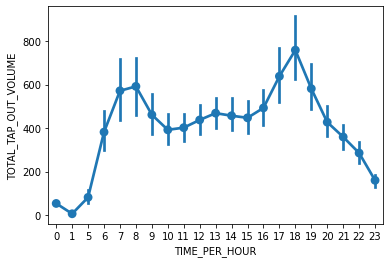

In [144]:
sns.pointplot(x=bus_df[bus_df.subzone=='kml_100'].TIME_PER_HOUR,y=bus_df[bus_df.subzone=='kml_100'].TOTAL_TAP_OUT_VOLUME)

In [145]:
# dir = f'carpark datasets/output_2021'

# all_files = glob.glob(dir + "/*.csv")
# carpark = pd.DataFrame()
# for f in all_files:
#         if f[29:36]=='2021-05' or f[29:36]=='2021-06' or f[29:36]=='2021-07':
#                 e=pd.read_csv(f)
#                 carpark = carpark.append(e[e.number.isin(['BJ49', 'CKM5', 'CK58', 'CK52', 'BM10', 'BJ48', 'JS3L', 'CK54','B79', 'CK78'])])
# carpark['occupied']=(carpark.total-carpark.available)/carpark.total*100
# carpark=carpark.sort_values(['number','time']).reset_index(drop=True)
# carpark['change']=carpark.occupied.diff()
# carpark['change'][carpark.time.str[11:16]=='00:04']=np.nan
# carpark.to_csv('carpark-changes.csv')

In [146]:
# yes=cp_weekend.groupby(['subzone',cp_weekend.time.dt.hour])['available','change'].mean()
# no=bus_weekend.groupby(['subzone','TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
# e = yes.merge(no,left_index=True,right_on=['subzone','TIME_PER_HOUR'])
# for i in e.index.droplevel(1).unique():
#     plt.figure()
#     sns.scatterplot(data=e[e.index.droplevel(1)==i],x='available',y='TOTAL_TAP_IN_VOLUME',hue='TIME_PER_HOUR').set(title=i)
#     # plt.figure()
#     # sns.scatterplot(data=e[e.index.droplevel(1)==i],x='available',y='TOTAL_TAP_OUT_VOLUME',hue='subzone')

In [147]:
cp_info = pd.read_csv('carpark-info.csv').drop(columns=['Unnamed: 0'])
# carpark=pd.read_csv('cp-mean-per-hour.csv').drop(columns=['Unnamed: 0'])
# carpark = carpark.merge(cp_info,left_on='number',right_on='car_park_no').drop(columns=['car_park_no','address'])
# carpark['time']=pd.to_datetime(carpark['time'])
# carpark['DoW'] = pd.to_datetime(carpark.time).dt.dayofweek
# carpark.head()

In [148]:
cp_weekday=pd.read_csv('cp-weekday-mean-hour.csv').merge(cp_info,left_on='number',right_on='car_park_no').drop(columns=['car_park_no','address'])
cp_weekday['available']=cp_weekday.available/cp_weekday.total*100
cp_weekend=pd.read_csv('cp-weekend-mean-hour.csv').merge(cp_info,left_on='number',right_on='car_park_no').drop(columns=['car_park_no','address'])
cp_weekend['available']=cp_weekend.available/cp_weekend.total*100
bus_weekday=bus_df[(bus_df.subzone.isin(cp_weekday.subzone))&(bus_df.DAY_TYPE=='WEEKDAY')].drop(columns=['RoadName'])
bus_weekend=bus_df[(bus_df.subzone.isin(cp_weekend.subzone))&(bus_df.DAY_TYPE=='WEEKENDS/HOLIDAY')].drop(columns=['RoadName'])

In [149]:
d=[]
for i in cp_weekday.subzone.unique():
    if i in bus_weekday.subzone.unique():
        d.append(i)
len(d)

151

In [151]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from scipy import stats
coeffs = []
for i in d:
    yes=cp_weekday[cp_weekday.subzone==i].groupby(['hour'])[['available']].mean().T.melt()
    no=bus_weekday[bus_weekday.subzone==i].groupby(['TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
    e = yes.merge(no,left_on='hour',right_on='TIME_PER_HOUR').sort_values(['hour'])
    a,b=stats.pearsonr(e.value,e.TOTAL_TAP_IN_VOLUME)
    coeffs.append(a)
    # x_train, x_test, y_train, y_test = train_test_split(e[['value']], e['TOTAL_TAP_IN_VOLUME'], test_size=0.2, random_state=0)
    # lm = LinearRegression()
    # lm.fit(x_train,y_train)

In [152]:
coeff_df = pd.DataFrame({'subzone':d,'value':coeffs})
coeff_df

,subzone,value
0,kml_329,0.466082
1,kml_242,0.427709
2,kml_330,0.449729
3,kml_172,0.358776
4,kml_163,0.334744
...,...,...
146,kml_219,0.409814
147,kml_222,0.424935
148,kml_299,0.277723
149,kml_226,-0.490995


In [153]:
subzones = gpd.read_file('regions.geojson').drop(columns='Description')
subzone_df=subzones.merge(coeff_df,left_on='Name',right_on='subzone',how='left').drop(columns='subzone')
subzone_df=subzone_df.fillna(0)
subzone_df

,Name,geometry,value
0,kml_1,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",0.000000
1,kml_2,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",0.000000
2,kml_3,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834...",0.000000
3,kml_4,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1...",0.000000
4,kml_5,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847...",0.000000
...,...,...,...
327,kml_328,"POLYGON Z ((103.84263 1.36323 0.00000, 103.842...",0.755456
328,kml_329,"POLYGON Z ((103.83537 1.37093 0.00000, 103.835...",0.466082
329,kml_330,"POLYGON Z ((103.84814 1.36879 0.00000, 103.848...",0.449729
330,kml_331,"POLYGON Z ((103.84652 1.34521 0.00000, 103.846...",0.620208


Text(0.5, 1.0, 'Correlation of car park availability and bus usage in Singapore')

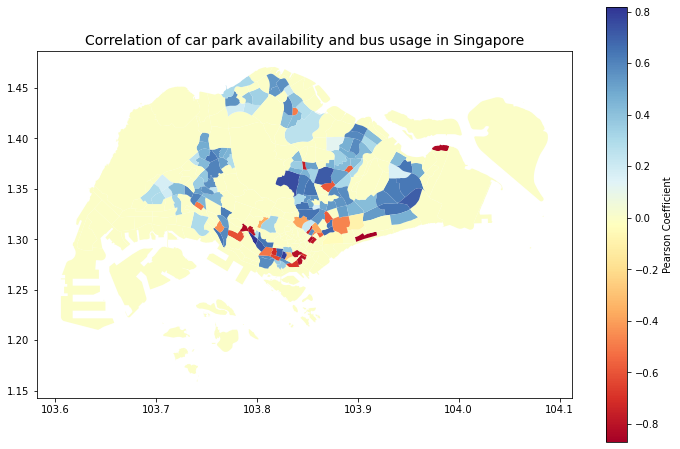

In [154]:
ax=subzone_df.plot(column='value',figsize=(12,8),cmap='RdYlBu',legend=True,
legend_kwds={'label': "Pearson Coefficient"})
ax.set_title('Correlation of car park availability and bus usage in Singapore',size=14)

Text(0.5, 1.0, 'Correlation of car park availability and bus usage in Singapore')

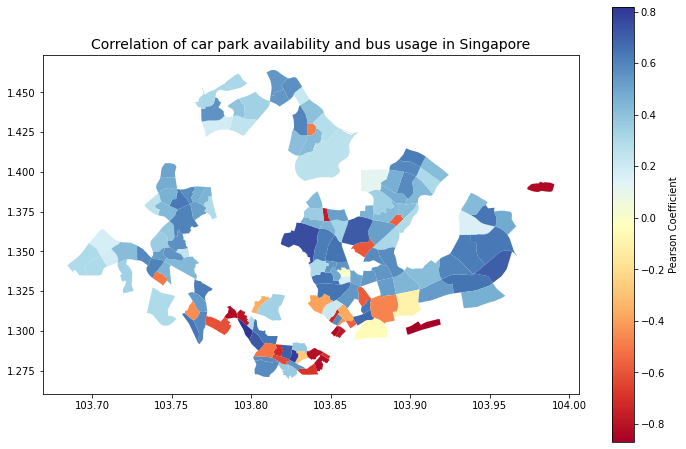

In [155]:
subzone_df=subzone_df[subzone_df.value!=0]
ax=subzone_df.plot(column='value',figsize=(12,8),cmap='RdYlBu',legend=True,
legend_kwds={'label': "Pearson Coefficient"})
ax.set_title('Correlation of car park availability and bus usage in Singapore',size=14)

In [156]:
coeffs2 = []
for i in d:
    yes=cp_weekend[cp_weekend.subzone==i].groupby(['hour'])[['available']].mean().T.melt()
    no=bus_weekend[bus_weekend.subzone==i].groupby(['TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
    e = yes.merge(no,left_on='hour',right_on='TIME_PER_HOUR').sort_values(['hour'])
    a,b=stats.pearsonr(e.value,e.TOTAL_TAP_IN_VOLUME)
    coeffs2.append(a)

In [157]:
coeff_df2 = pd.DataFrame({'subzone':d,'value':coeffs2})
subzone_df2=subzones.merge(coeff_df2,left_on='Name',right_on='subzone',how='left').drop(columns='subzone')
subzone_df2=subzone_df2.fillna(0)
subzone_df2

,Name,geometry,value
0,kml_1,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",0.000000
1,kml_2,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",0.000000
2,kml_3,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834...",0.000000
3,kml_4,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1...",0.000000
4,kml_5,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847...",0.000000
...,...,...,...
327,kml_328,"POLYGON Z ((103.84263 1.36323 0.00000, 103.842...",0.443425
328,kml_329,"POLYGON Z ((103.83537 1.37093 0.00000, 103.835...",0.370307
329,kml_330,"POLYGON Z ((103.84814 1.36879 0.00000, 103.848...",0.378232
330,kml_331,"POLYGON Z ((103.84652 1.34521 0.00000, 103.846...",0.833579


Text(0.5, 1.0, 'Correlation of car park availability and bus usage in Singapore (weekend)')

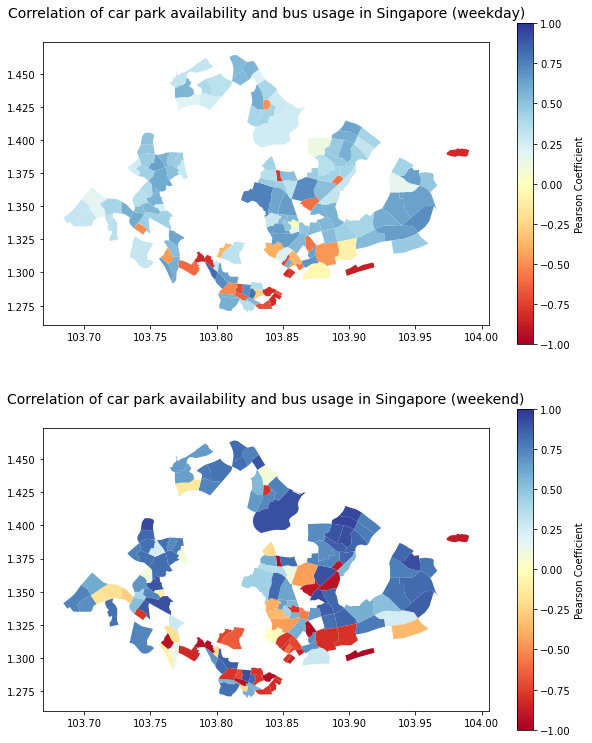

In [187]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,13))

subzone_df=subzone_df[subzone_df.value!=0]
subzone_df.plot(column='value',figsize=(12,8),cmap='RdYlBu',legend=True,ax=ax1,
legend_kwds={'label': "Pearson Coefficient"},vmin=-1,vmax=1)
ax1.set_title('Correlation of car park availability and bus usage in Singapore (weekday)',size=14,pad=25)


subzone_df2=subzone_df2[subzone_df2.value!=0]
ax2=subzone_df2.plot(column='value',figsize=(12,8),cmap='RdYlBu',legend=True,ax=ax2,
legend_kwds={'label': "Pearson Coefficient"},vmin=-1,vmax=1)
ax2.set_title('Correlation of car park availability and bus usage in Singapore (weekend)',size=14,pad=25)

In [159]:
carpark

,period,number,total,available,avail_percent,address,x_coord,y_coord,subzone
0,2021-05,A10,1984,758,0.382,BLK 201/202 ANG MO KIO STREET 22,103.844524,1.368633,kml_329
1,2021-06,A10,1920,752,0.392,BLK 201/202 ANG MO KIO STREET 22,103.844524,1.368633,kml_329
2,2021-07,A10,576,242,0.420,BLK 201/202 ANG MO KIO STREET 22,103.844524,1.368633,kml_329
3,2021-05,A100,1984,1008,0.508,BLK 650 ANG MO KIO STREET 61,103.842603,1.377987,kml_242
4,2021-06,A100,1920,1003,0.522,BLK 650 ANG MO KIO STREET 61,103.842603,1.377987,kml_242
...,...,...,...,...,...,...,...,...,...
5617,2021-06,Y9,7860,4071,0.518,BLK 747/752 YISHUN STREET 72,103.834013,1.427831,kml_302
5618,2021-07,Y9,2358,1263,0.536,BLK 747/752 YISHUN STREET 72,103.834013,1.427831,kml_302
5619,2021-05,YHS,1970,557,0.283,BLK 11/12/13 YORK HILL CAR PARK,103.837887,1.286501,kml_37
5620,2021-06,YHS,1903,607,0.319,BLK 11/12/13 YORK HILL CAR PARK,103.837887,1.286501,kml_37


In [172]:
top10=carpark.groupby('subzone').total.sum().sort_values(ascending=False)[:10].index
top10

Index(['kml_179', 'kml_312', 'kml_199', 'kml_265', 'kml_260', 'kml_156',
       'kml_105', 'kml_213', 'kml_257', 'kml_243'],
      dtype='object', name='subzone')

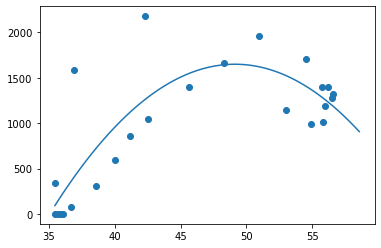

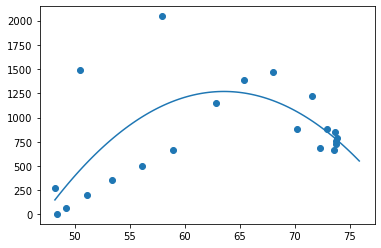

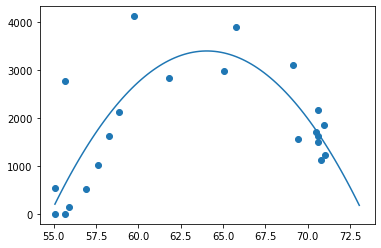

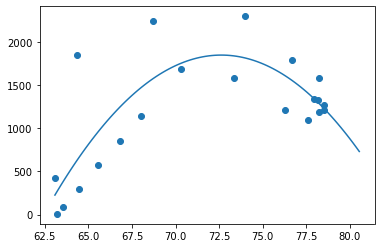

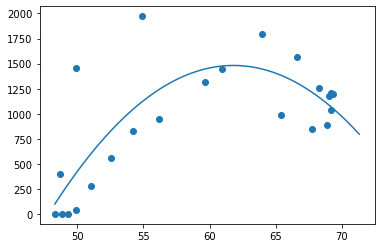

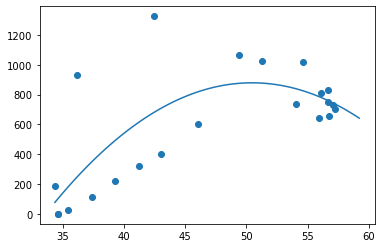

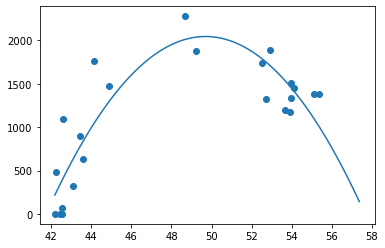

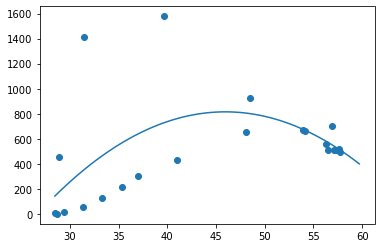

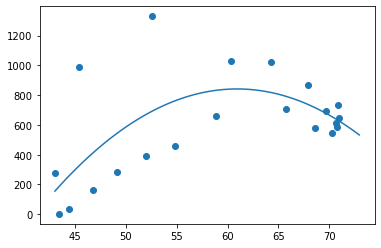

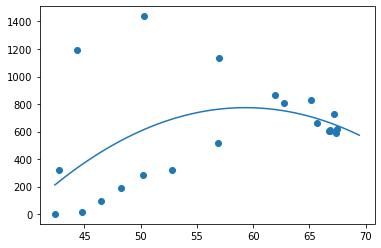

In [199]:
for i in top10:
    yes=cp_weekday[cp_weekday.subzone==i].groupby(['hour'])[['available']].mean().T.melt()
    no=bus_weekday[bus_weekday.subzone==i].groupby(['TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
    e = yes.merge(no,left_on='hour',right_on='TIME_PER_HOUR').sort_values(['hour'])
    plt.figure()
    plt.scatter(e.value, e.TOTAL_TAP_IN_VOLUME)
    line = np.linspace(e.value.min(), e.value.max()+2, 100)
    model = np.poly1d(np.polyfit(e.value, e.TOTAL_TAP_IN_VOLUME, 2))
    plt.plot(line, model(line))

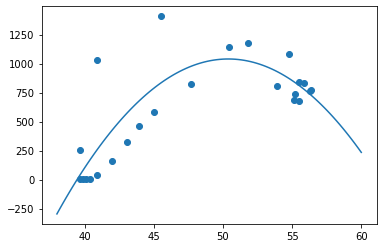

In [198]:
yes=cp_weekday.groupby(['hour'])[['available']].mean().T.melt()
no=bus_weekday.groupby(['TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
e = yes.merge(no,left_on='hour',right_on='TIME_PER_HOUR').sort_values(['hour'])
plt.scatter(e.value, e.TOTAL_TAP_IN_VOLUME)
line = np.linspace(38, 60, 100)
model = np.poly1d(np.polyfit(e.value, e.TOTAL_TAP_IN_VOLUME, 2))
plt.plot(line, model(line))

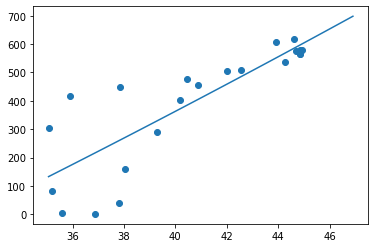

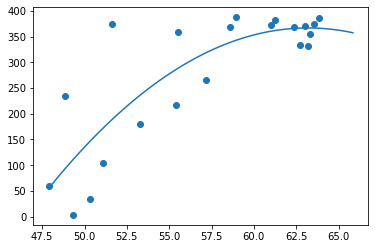

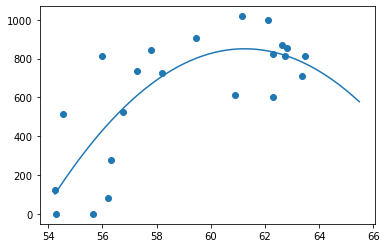

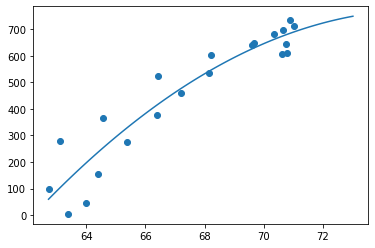

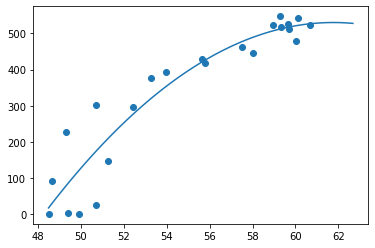

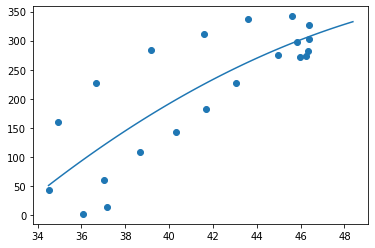

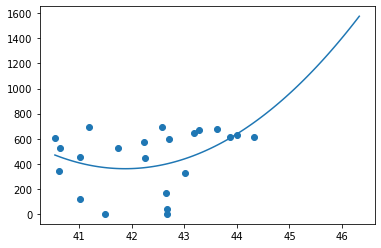

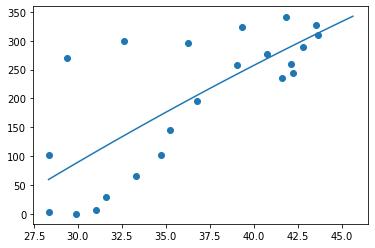

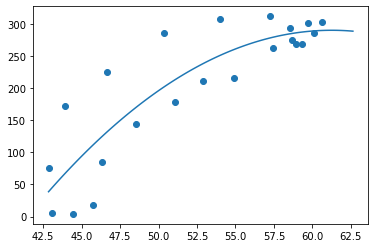

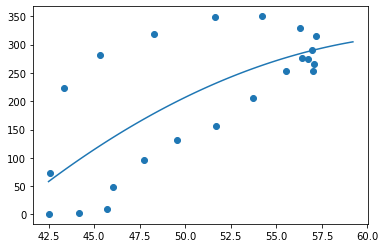

In [197]:
for i in top10:
    yes=cp_weekend[cp_weekend.subzone==i].groupby(['hour'])[['available']].mean().T.melt()
    no=bus_weekend[bus_weekend.subzone==i].groupby(['TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
    e = yes.merge(no,left_on='hour',right_on='TIME_PER_HOUR').sort_values(['hour'])
    plt.figure()
    plt.scatter(e.value, e.TOTAL_TAP_IN_VOLUME)
    line = np.linspace(e.value.min(), e.value.max()+2, 100)
    model = np.poly1d(np.polyfit(e.value, e.TOTAL_TAP_IN_VOLUME, 2))
    plt.plot(line, model(line))

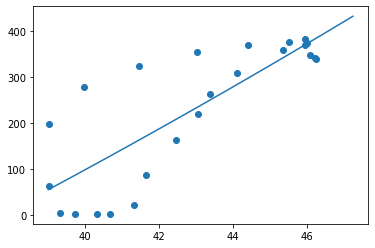

In [196]:
yes=cp_weekend.groupby(['hour'])[['available']].mean().T.melt()
no=bus_weekend.groupby(['TIME_PER_HOUR'])['TOTAL_TAP_IN_VOLUME','TOTAL_TAP_OUT_VOLUME'].mean()
e = yes.merge(no,left_on='hour',right_on='TIME_PER_HOUR').sort_values(['hour'])
plt.scatter(e.value, e.TOTAL_TAP_IN_VOLUME)
line = np.linspace(e.value.min(), e.value.max()+1, 100)
model = np.poly1d(np.polyfit(e.value, e.TOTAL_TAP_IN_VOLUME, 2))
plt.plot(line, model(line))